In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd
import pandas as pd
import smps
import numpy as np
import joblib
import json
import seaborn as sns
import seaborn.objects as so
import plotly as py
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot
from matplotlib.markers import MarkerStyle
from matplotlib.lines import Line2D
from smps.fit import LogNormal
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter
sns.set("notebook", "ticks", palette='Paired') 
%matplotlib inline

# 1. Read in Processced Data (No fogging, Shortened)

## 1.1 Timeseries files (already resampled to 6 min)

In [2]:
folder = '/Users/zahrashivji/Dropbox/Shivji/Final Data/Outdoor Files/'

data = dd.read_csv(
    folder + 'timeseries_forIgor.csv',
    parse_dates=['timestamp']
).compute()

# Set the index to be the timestamp
data.set_index("timestamp", inplace=True) 

In [3]:
data.columns

Index(['Median (nm)', 'Mean (nm)', 'Mode (nm)', 'Geo. Mean (nm)', 'PM1_SMPS',
       'PM1_ACSM', 'PM_350_SMPS', 'PM_300_SMPS', '% > 350nm', '% > 300nm',
       'PM1_modpm', 'PM25_modpm', 'PM10_modpm', 'PM1-25_modpm',
       'PM25-10_modpm', 'PM1_frac_modpm', 'PM25_frac_modpm', 'PM10_frac_modpm',
       'PM1_neph', 'PM25_neph', 'PM10_neph', 'PM1-25_neph', 'PM25-10_neph',
       'PM1_frac_neph', 'PM25_frac_neph', 'PM10_frac_neph', 'PM25/PM1_neph',
       'PM25/PM1_modpm', 'unknown', 'BBOA', 'COA', 'HOA', 'LO-OOA', 'MO-OOA',
       'BBOA_fraction', 'COA_fraction', 'HOA_fraction', 'LO-OOA_fraction',
       'MO-OOA_fraction', 'Org_CE', 'SO4_CE', 'NO3_CE', 'NH4_CE', 'Chl_CE',
       'PMS PM1 bias', 'modpm PM1 bias', 'temp', 'rh'],
      dtype='object')

## 1.2 Bias Plot files 

### 1.2.1 Geo. Mean Diameter (GM)

In [95]:
gm = dd.read_csv(
    folder + 'gm_forIgor.csv'
).compute()

### 1.2.2 Relative Humidity (RH)

In [96]:
rh = dd.read_csv(
    folder + 'rh_forIgor.csv'
).compute()

### 1.2.3 SMPS PM1 Mass Loading (ML)

In [97]:
ml = dd.read_csv(
    folder + 'ml_forIgor.csv'
).compute()

## 1.3 SMPS

In [4]:
folder = '/Users/zahrashivji/Dropbox/Shivji/Final Data/Outdoor Files/'

df2 = pd.read_csv(
    folder + 'SMPS_forIgor.csv',
    parse_dates=['timestamp']
)

#Set the index for the data dataframe
df2.set_index('timestamp',inplace=True)

#Determine the total number of channels
n_channels =113

#Next determine the index of the first channel
channel0_idx = 8

mid = pd.read_csv(
    folder + '20210225_SMPS_NumberDistributions_JCR.csv',
    skiprows = 23
)

#Grab the bin diameters
midpoints = mid.columns[channel0_idx:channel0_idx+n_channels]
binlabels = ['bin{}'.format(i) for i in range(n_channels)]

# Build out a nx3 array of the bin boundaries
bins = smps.utils.make_bins(
    midpoints=midpoints,
    lb = df2['Lower Size (nm)'][0],
    ub = df2['Upper Size (nm)'][0],
    channels_per_decade=64,
)

#B uild a generic Particle Sizer Object 
obj = smps.GenericParticleSizer(
    data=df2.copy(),
    bins=bins,
    fmt='dn',
    dp_units='nm',
    bin_labels=binlabels
)

In [216]:
obj.data.index

DatetimeIndex(['2020-11-05 00:00:00', '2020-11-05 00:06:00',
               '2020-11-05 00:12:00', '2020-11-05 00:18:00',
               '2020-11-05 00:24:00', '2020-11-05 00:30:00',
               '2020-11-05 00:36:00', '2020-11-05 00:42:00',
               '2020-11-05 00:48:00', '2020-11-05 00:54:00',
               ...
               '2021-01-01 23:00:00', '2021-01-01 23:06:00',
               '2021-01-01 23:12:00', '2021-01-01 23:18:00',
               '2021-01-01 23:24:00', '2021-01-01 23:30:00',
               '2021-01-01 23:36:00', '2021-01-01 23:42:00',
               '2021-01-01 23:48:00', '2021-01-01 23:54:00'],
              dtype='datetime64[ns]', name='timestamp', length=13920, freq=None)

# 2. Plots

In [5]:
folder = "/Users/zahrashivji/Dropbox/Shivji/Final Figures/Outdoor/"

## 2.1 Timeseries

In [100]:
# force 'normal' text style for math text
mpl.rcParams['mathtext.default'] = 'regular'

def major_ticks(x, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    x = mdates.num2date(x)
    if pos == 0:
        fmt = "%-d\n%-m\n%I\n%-M"
    else:
        fmt = "%-d"
    return x.strftime(fmt)

# set global seaborn params
sns.set("paper", "ticks", color_codes=True, palette='Paired')

# set up the matplotlib figure
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 8), edgecolor  = 'black', sharex=True)

# grab the current color palette
cmap = sns.color_palette("Paired")

# plot the PM10 data
ax[0].plot(data['PM10_modpm'], lw=1.5, label="MODULAIR-PM", color=cmap[7])
ax[0].plot(data['PM10_neph'], lw=1.5, label='PMS', color=cmap[6])
ax[0].set_ylabel("$PM_10 \; [\mu g m^{-3}]$")
ax[0].set_ylim(-0.1, None)
ax[0].set_xlim('2020-11-05 00:00', '2021-01-01')
ax[0].legend(loc = 'upper left')

# plot the o3, so2, and no2 data on the second axis
ax[1].plot(data['PM25_modpm'], lw=1.5, label="MODULAIR-PM", color=cmap[3])
ax[1].plot(data['PM25_neph'], lw=1.5, label='PMS', color=cmap[2])
ax[1].set_ylabel("$PM_2.5 \; [\mu g m^{-3}]$")
ax[1].set_ylim(-0.1, None)
ax[1].legend(loc = 'upper left')

# plot the OPC bins on the third row (Of MODULAIR)
ax[2].plot(data['PM1_modpm'], lw=1.5, label="MODULAIR-PM", color=cmap[1])
ax[2].plot(data['PM1_neph'], lw=1.5, label='PMS', color=cmap[0])
ax[2].plot(data['PM1_SMPS'], lw=1.5, label='SMPS', color='darkgray', linestyle='dashed', zorder = 0)
ax[2].plot(data['PM1_ACSM'], lw=1.5, label='ACSM', color='black', linestyle='dashed', zorder = 1)
ax[2].set_ylabel("$PM_1 \; [\mu g m^{-3}]$")
ax[2].set_ylim(-0.1, None)
ax[2].legend(loc = 'upper left')

# # label the panels
# pct = 0.9
# ax[0].text("04-08 00", pct*ax[0].get_ylim()[-1], "(a)")
# ax[1].text("04-08 00", pct*ax[1].get_ylim()[-1], "(b)")
# ax[2].text("04-08 00", pct*ax[2].get_ylim()[-1], "(c)")

# set titles for each panel
ax[0].set_title("PM10", fontsize=12)
ax[1].set_title("PM2.5", fontsize=12)
ax[2].set_title("PM1", fontsize=12)

# # remove the tiop and right spine
# sns.despine()

# force a tight layout
plt.tight_layout()

# # save the figure
# fig.savefig(folder+'timeseries_whole_period.png', dpi=350, bbox_inches='tight')

fig.show()
plt.close(fig)

/var/folders/3x/bzpq51ls1_q2l69w2sj38xym0000gn/T/ipykernel_92511/3425909650.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [101]:
# # set the label fontsize
# xy_label_fontsize = 12

# force 'normal' text style for math text
mpl.rcParams['mathtext.default'] = 'regular'

def x_major_ticks(x, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    x = mdates.num2date(x)
    fmt = "%a %-m-%-d \n%I:%M %p"
    
    return x.strftime(fmt)

def y_major_ticks(y, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    y = int(y)
    
    return y

# set global seaborn params
sns.set("paper", "ticks", color_codes=True, palette='Paired')

# set up the matplotlib figure
fig, ax = plt.subplots(figsize = [8.5, 3.5], dpi = 350)

# grab the current color palette
cmap = sns.color_palette("Paired")

# plot the PM1 data
plt.plot(data['PM1_modpm'], lw=1.5, label="MODULAIR-PM", color=cmap[1])
plt.plot(data['PM1_neph'], lw=1.5, label='PMS', color=cmap[0])
plt.plot(data['PM1_SMPS'], lw=1.5, label='SMPS', color='darkgray', linestyle='dashed', zorder = 0)
plt.plot(data['PM1_ACSM'], lw=1.5, label='ACSM', color='black', linestyle='dashed', zorder = 1)
plt.ylabel("$PM_{1} \; [\mu g m^{-3}]$")
plt.xlim('2020-11-05 00:00', '2021-01-01')
plt.legend(loc = 'upper left')

ax.xaxis.set_major_formatter(x_major_ticks)
ax.yaxis.set_major_formatter(y_major_ticks)

# # remove the tiop and right spine
# sns.despine()

# force a tight layout
plt.tight_layout()

# save the figure
plt.savefig(
    folder + "Timeseries_PM1.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
plt.close(fig)

In [102]:
# # set the label fontsize
# xy_label_fontsize = 12

# force 'normal' text style for math text
mpl.rcParams['mathtext.default'] = 'regular'

def x_major_ticks(x, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    x = mdates.num2date(x)
    fmt = "%a %-m-%-d \n%I:%M %p"
    
    return x.strftime(fmt)

def y_major_ticks(y, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    y = int(y)
    
    return y

# set global seaborn params
sns.set("paper", "ticks", color_codes=True, palette='Paired')

# set up the matplotlib figure
fig, ax = plt.subplots(figsize = [8.5, 3.5], dpi = 350)

# grab the current color palette
cmap = sns.color_palette("Paired")

# plot the PM10 data
plt.plot(data['PM25_modpm'], lw=1.5, label="MODULAIR-PM", color=cmap[3])
plt.plot(data['PM25_neph'], lw=1.5, label='PMS', color=cmap[2])
plt.ylabel("$PM_{2.5} \; [\mu g m^{-3}]$")
plt.xlim('2020-11-05 00:00', '2021-01-01')
plt.legend(loc = 'upper left')

ax.xaxis.set_major_formatter(x_major_ticks)
ax.yaxis.set_major_formatter(y_major_ticks)

# # remove the tiop and right spine
# sns.despine()

# force a tight layout
plt.tight_layout()

# save the figure
plt.savefig(
    folder + "Timeseries_PM25.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
plt.close(fig)

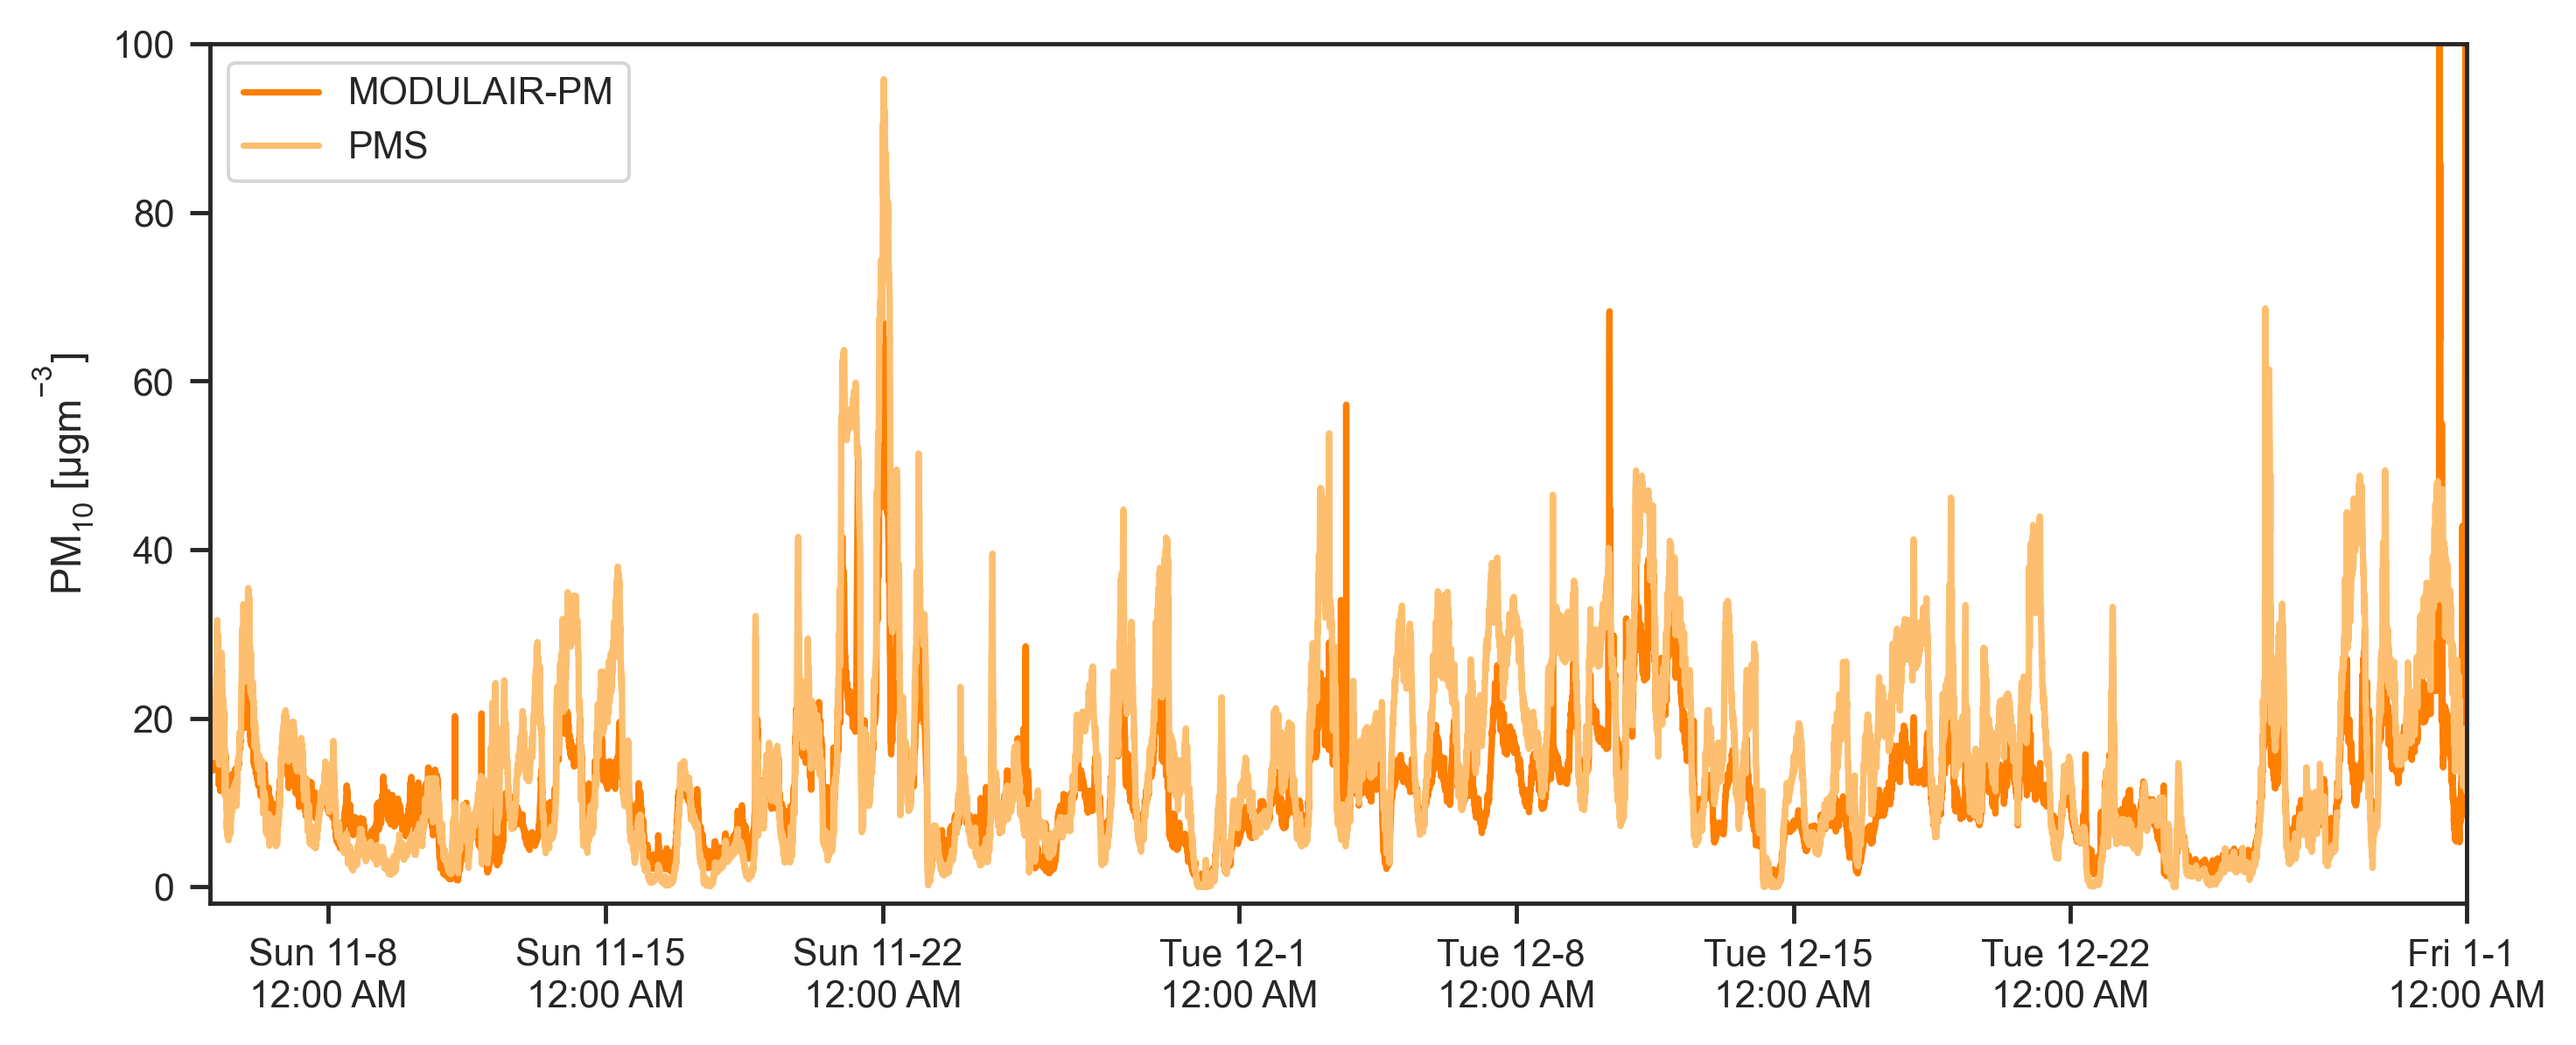

In [10]:
# # set the label fontsize
# xy_label_fontsize = 12

# force 'normal' text style for math text
mpl.rcParams['mathtext.default'] = 'regular'

def x_major_ticks(x, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    x = mdates.num2date(x)
    fmt = "%a %-m-%-d \n%I:%M %p"
    
    return x.strftime(fmt)

def y_major_ticks(y, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    y = int(y)
    
    return y

# set global seaborn params
sns.set("paper", "ticks", color_codes=True, palette='Paired')

# set up the matplotlib figure
fig, ax = plt.subplots(figsize = [8.5, 3.5], dpi = 350)

# grab the current color palette
cmap = sns.color_palette("Paired")

# plot the PM10 data
plt.plot(data['PM10_modpm'], lw=1.5, label="MODULAIR-PM", color=cmap[7])
plt.plot(data['PM10_neph'], lw=1.5, label='PMS', color=cmap[6])
plt.ylabel("$PM_{10} \; [\mu g m^{-3}]$")
plt.xlim('2020-11-05 00:00', '2021-01-01')
plt.legend(loc = 'upper left')
plt.ylim(-2, 100)

ax.xaxis.set_major_formatter(x_major_ticks)
ax.yaxis.set_major_formatter(y_major_ticks)

# # remove the tiop and right spine
# sns.despine()

# force a tight layout
plt.tight_layout()

# save the figure
plt.savefig(
    folder + "Timeseries_PM10.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
# plt.close(fig)

In [104]:
# """
# """
# import numpy as np
# import seaborn as sns
# import joblib
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# import matplotlib.dates as mdates
# import matplotlib.ticker as mticker
# from matplotlib.ticker import FuncFormatter

# # set the label fontsize
# xy_label_fontsize = 12

# # force 'normal' text style for math text
# mpl.rcParams['mathtext.default'] = 'regular'

# def major_ticks(x, pos=None):
#     """Set the major ticks according 
#     to this custom style
#     """
#     x = mdates.num2date(x)
#     if pos == 0:
#         fmt = "%-d\n%-m\n%I\n%-M"
#     else:
#         fmt = "%-d"
#     return x.strftime(fmt)

# # set global seaborn params
# sns.set("paper", "ticks", color_codes=True, palette='Paired')

# # set up the matplotlib figure
# fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), edgecolor  = 'black', sharex=True)

# # grab the current color palette
# cmap = sns.color_palette("Paired")

# # plot the PM10 data
# # plot the chemical composition data from the ACSM on row 4

# ax[0].fill_between(tmp.index, tmp['Chl'], lw=0, label='Cl', color='k')

# ax[0].fill_between(tmp.index, y1=tmp['Chl'], y2=tmp[['Chl', 'NH4']].sum(axis=1),
#                     lw=0, color='pink', label='$NH_4$')

# ax[0].fill_between(tmp.index, y1=tmp[['Chl', 'NH4']].sum(axis=1),
#             y2=tmp[['Chl', 'NH4','NO3']].sum(axis=1), lw=0, label='$NO_3$',
#             color=cmap[1])

# ax[0].fill_between(tmp.index, y1=tmp[['Chl', 'NH4','NO3']].sum(axis=1),
#             y2=tmp[['Chl', 'NH4','NO3','SO4']].sum(axis=1), lw=0, label='$SO_4$',
#             color=cmap[0])

# ax[0].fill_between(tmp.index, y1=tmp[['Chl', 'NH4','NO3','SO4']].sum(axis=1),
#             y2=tmp[['Chl', 'NH4','NO3','SO4','Org']].sum(axis=1), lw=0,
#             label='Org', color='g')

# ax[0].set_ylim(0, None)
# ax[0].set_ylabel("$PM_1 \; [\mu g m^{-3}]$")
# ax[0].legend(bbox_to_anchor=(1.12, 1.2), ncol=1)

# # plot the chemical composition data from the ACSM

# ax[1].fill_between(tmp.index, tmp['Chl'], lw=0, label='Cl', color='k')

# ax[1].fill_between(tmp.index, y1=tmp['Chl'], y2=tmp[['Chl', 'NH4']].sum(axis=1),
#                     lw=0, color='pink', label='$NH_4$')

# ax[1].fill_between(tmp.index, y1=tmp[['Chl', 'NH4']].sum(axis=1),
#             y2=tmp[['Chl', 'NH4','NO3']].sum(axis=1), lw=0, label='$NO_3$',
#             color=cmap[1])

# ax[1].fill_between(tmp.index, y1=tmp[['Chl', 'NH4','NO3']].sum(axis=1),
#             y2=tmp[['Chl', 'NH4','NO3','SO4']].sum(axis=1), lw=0, label='$SO_4$',
#             color=cmap[0])

# ax[1].fill_between(tmp.index, y1=tmp[['Chl', 'NH4','NO3','SO4']].sum(axis=1),
#             y2=tmp[['Chl', 'NH4','NO3','SO4','Org']].sum(axis=1), lw=0,
#             label='Org', color='g')

# ax[1].set_ylim(0, None)
# ax[1].set_ylabel("$PM_1 \; [\mu g m^{-3}]$")
# ax[1].legend(bbox_to_anchor=(1.12, 1.2), ncol=1)

# # # label the panels
# # pct = 0.9
# # ax[0].text("04-08 00", pct*ax[0].get_ylim()[-1], "(a)")
# # ax[1].text("04-08 00", pct*ax[1].get_ylim()[-1], "(b)")
# # ax[2].text("04-08 00", pct*ax[2].get_ylim()[-1], "(c)")

# # set titles for each panel
# ax[0].set_title("PM10", fontsize=12)
# ax[1].set_title("PM2.5", fontsize=12)
# ax[2].set_title("PM1", fontsize=12)

# # remove the tiop and right spine
# sns.despine()

# # force a tight layout
# plt.tight_layout()

# # # save the figure
# # fig.savefig(folder+'timeseries_whole_period.png', dpi=350, bbox_inches='tight')

# fig.show()

## 2.2 Scatter Plots

### 2.2.1 PM1 

In [14]:
import statsmodels.formula.api as smf

dat = data

results = smf.ols("PM1_modpm ~ PM1_SMPS",data=dat).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              PM1_modpm   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                 6.014e+04
Date:                Sat, 05 Nov 2022   Prob (F-statistic):               0.00
Time:                        18:58:57   Log-Likelihood:                -34081.
No. Observations:               13701   AIC:                         6.817e+04
Df Residuals:                   13699   BIC:                         6.818e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2001      0.041     28.973      0.0

In [15]:
import statsmodels.formula.api as smf

dat = data

results = smf.ols("PM1_neph ~ PM1_SMPS",data=dat).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               PM1_neph   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                 7.636e+04
Date:                Sat, 05 Nov 2022   Prob (F-statistic):               0.00
Time:                        18:58:57   Log-Likelihood:                -33333.
No. Observations:               13701   AIC:                         6.667e+04
Df Residuals:                   13699   BIC:                         6.669e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6374      0.039     16.252      0.0

In [16]:
import statsmodels.formula.api as smf

dat = data

results = smf.ols("PM1_neph ~ PM1_modpm",data=dat).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               PM1_neph   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                 7.052e+04
Date:                Sat, 05 Nov 2022   Prob (F-statistic):               0.00
Time:                        18:58:57   Log-Likelihood:                -34350.
No. Observations:               13915   AIC:                         6.870e+04
Df Residuals:                   13913   BIC:                         6.872e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3898      0.042      9.390      0.0

In [17]:
x_smps = [data['PM1_SMPS'].min(), data['PM1_SMPS'].max()]
y_neph = [data['PM1_SMPS'].min()*0.9560+0.6374, data['PM1_SMPS'].max()*0.9560+0.6374]
y_modpm = [data['PM1_SMPS'].min()*0.8960+1.2001, data['PM1_SMPS'].max()*0.8960+1.2001]

In [169]:
folder = "/Users/zahrashivji/Dropbox/Shivji/Final Figures/Outdoor/"

fig = plt.figure(figsize = [4, 4], dpi = 350)

cmap = sns.color_palette("Paired")

# Add scatter points
plt.scatter(
    data["PM1_SMPS"], 
    data["PM1_neph"], 
    marker = MarkerStyle('o'),
    alpha = 0.7,
    color = cmap[0],
    label = 'PMS')

# Add scatter points
plt.scatter(
    data["PM1_SMPS"], 
    data["PM1_modpm"], 
    marker = MarkerStyle('o'),
    alpha = 0.5,
    color = cmap[1],
    label = 'MODULAIR-PM',
    zorder = 0)

# Add x=y line
plt.axline(
    [0, 0],
    [1, 1],
    c = 'black',
    dashes = (5, 5), lw= 1)

# Add ols trendline
plt.plot(
    x_smps,
    y_neph,
    color = cmap[0])

# Add ols trendline
plt.plot(
    x_smps,
    y_modpm,
    color = cmap[1])

plt.xlabel("SMPS  " + "$PM_{1}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylabel("LCS  " + "$PM_{1}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylim(-0.5, 85)
plt.xlim(-0.5, 85)
plt.legend(loc = 'upper left')
plt.annotate('y=0.96+0.64 \n $R^2$ = 0.85', (35, 60), c = cmap[0])
plt.annotate('y=0.90+1.20 \n $R^2$ = 0.81', (60,20), c = cmap[1])

plt.tight_layout()

plt.savefig(
    folder + "Scatter_PM1.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
plt.close(fig)

### 2.2.2 PM2.5

In [109]:
import statsmodels.formula.api as smf

dat = data

results = smf.ols("PM25_neph ~ PM25_modpm",data=dat).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              PM25_neph   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                 5.250e+04
Date:                Tue, 01 Nov 2022   Prob (F-statistic):               0.00
Time:                        09:12:58   Log-Likelihood:                -41886.
No. Observations:               13915   AIC:                         8.378e+04
Df Residuals:                   13913   BIC:                         8.379e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1405      0.073      1.914      0.0

In [110]:
x_modpm_pm25 = [data['PM25_modpm'].min(), data['PM25_modpm'].max()]
y_neph_pm25 = [data['PM25_modpm'].min()*1.3965+0.1405, data['PM25_modpm'].max()*1.3965+0.1405]

In [139]:
folder = "/Users/zahrashivji/Dropbox/Shivji/Final Figures/Outdoor/"

fig = plt.figure(figsize = [4, 4], dpi = 350)

cmap = sns.color_palette("Paired")

# Add scatter points
plt.scatter(
    data["PM25_modpm"], 
    data["PM25_neph"], 
    marker = MarkerStyle('o'),
    alpha = 0.3,
    color = cmap[3])

# Add x=y line
plt.axline(
    [0, 0],
    [1, 1],
    c = 'black',
    dashes = (5, 5), lw= 1)

# Add ols trendline
plt.plot(
    x_modpm_pm25,
    y_neph_pm25,
    color = cmap[3])

plt.xlabel("MODULAIR-PM  " + "$PM_{2.5}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylabel("PMS  " + "$PM_{2.5}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylim(-1.5, 100)
plt.xlim(-1.5, 100)
plt.annotate('y = 1.40x+0.14 \n $R^2$ = 0.79', (60,20), c = 'black')

plt.tight_layout()

plt.savefig(
    folder + "Scatter_PM25.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
plt.close(fig)

### 2.2.3 PM10

In [112]:
import statsmodels.formula.api as smf

dat = data

results = smf.ols("PM10_neph ~ PM10_modpm",data=dat).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              PM10_neph   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                 2.674e+04
Date:                Tue, 01 Nov 2022   Prob (F-statistic):               0.00
Time:                        09:13:01   Log-Likelihood:                -47050.
No. Observations:               13915   AIC:                         9.410e+04
Df Residuals:                   13913   BIC:                         9.412e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6335      0.108      5.870      0.0

In [113]:
x_modpm_pm10 = [data['PM10_modpm'].min(), data['PM10_modpm'].max()]
y_neph_pm10 = [data['PM10_modpm'].min()*1.2760+0.6335, data['PM10_modpm'].max()*1.2760+0.6335]

In [114]:
folder = "/Users/zahrashivji/Dropbox/Shivji/Final Figures/Outdoor/"

def y_major_ticks(y, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    y = int(y)
    
    return y

fig, ax = plt.subplots(figsize = [4, 4], dpi = 350)

cmap = sns.color_palette("Paired")

# Add scatter points
plt.scatter(
    data["PM10_modpm"], 
    data["PM10_neph"], 
    marker = MarkerStyle('o'),
    alpha = 0.3,
    color = cmap[7])

# Add x=y line
plt.axline(
    [0, 0],
    [1, 1],
    c = 'black',
    dashes = (5, 5), lw= 1)

# Add ols trendline
plt.plot(
    x_modpm_pm10,
    y_neph_pm10,
    color = cmap[7])

plt.xlabel("MODULAIR-PM  " + "$PM_{10}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylabel("PMS  " + "$PM_{10}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylim(-3, 200)
plt.xlim(-3, 200)
plt.annotate('y = 1.3x+0.63 \n $R^2$ = 0.66', (120,75), c = 'black')

ax.yaxis.set_major_formatter(y_major_ticks)

plt.tight_layout()

plt.savefig(
    folder + "Scatter_PM10.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
plt.close(fig)

## 2.3 Large Particle Plots 

### 2.3.1 PM2.5-PM1

In [115]:
# # set the label fontsize
# xy_label_fontsize = 12

# force 'normal' text style for math text
mpl.rcParams['mathtext.default'] = 'regular'

def x_major_ticks(x, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    x = mdates.num2date(x)
    fmt = "%a %-m-%-d \n%I:%M %p"
    
    return x.strftime(fmt)

def y_major_ticks(y, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    y = int(y)
    
    return y

# set global seaborn params
sns.set("paper", "ticks", color_codes=True, palette='Paired')

# set up the matplotlib figure
fig, ax = plt.subplots(figsize = [8.5, 3.5], dpi = 350)

# grab the current color palette
cmap = sns.color_palette("Paired")

# plot the PM10 data
plt.plot(data['PM1-25_modpm'], lw=1.5, label="MODULAIR-PM", color=cmap[3])
plt.plot(data['PM1-25_neph'], lw=1.5, label='PMS', color=cmap[2])
plt.ylabel("$PM_{1-2.5} \; [\mu g m^{-3}]$")
plt.xlim('2020-11-05 00:00', '2021-01-01')
plt.legend(loc = 'upper left')

ax.xaxis.set_major_formatter(x_major_ticks)

# # remove the tiop and right spine
# sns.despine()

# force a tight layout
plt.tight_layout()

# save the figure
plt.savefig(
    folder + "Timeseries_PM1-25.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
plt.close(fig)

In [116]:
import statsmodels.formula.api as smf

tmp = data.copy()[["PM1-25_neph" , "PM1-25_modpm"]]
tmp.rename(columns = {'PM1-25_neph':'PM1_25_neph', 'PM1-25_modpm':'PM1_25_modpm'}, inplace = True)

dat = tmp

results = smf.ols("PM1_25_neph ~ PM1_25_modpm",data=dat).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            PM1_25_neph   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     326.0
Date:                Tue, 01 Nov 2022   Prob (F-statistic):           4.79e-72
Time:                        09:13:09   Log-Likelihood:                -38533.
No. Observations:               13915   AIC:                         7.707e+04
Df Residuals:                   13913   BIC:                         7.708e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.1734      0.042     99.770   

In [117]:
x_modpm_pm1_25 = [data['PM1-25_modpm'].min(), data['PM1-25_modpm'].max()]
y_neph_pm1_25 = [data['PM1-25_modpm'].min()*0.8631+4.1734, data['PM1-25_modpm'].max()*0.8631+4.1734]

In [118]:
folder = "/Users/zahrashivji/Dropbox/Shivji/Final Figures/Outdoor/"

fig = plt.figure(figsize = [4, 4], dpi = 350)

cmap = sns.color_palette("Paired")

# Add scatter points
plt.scatter(
    data["PM1-25_modpm"], 
    data["PM1-25_neph"], 
    marker = MarkerStyle('o'),
    alpha = 0.3,
    color = cmap[3])

# Add x=y line
plt.axline(
    [0, 0],
    [1, 1],
    c = 'black',
    dashes = (5, 5), lw= 1)

# Add ols trendline
plt.plot(
    x_modpm_pm1_25,
    y_neph_pm1_25,
    color = cmap[3])

plt.xlabel("MODULAIR-PM  " + "$PM_{1-2.5}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylabel("PMS  " + "$PM_{1-2.5}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylim(-0.8, 40)
plt.xlim(-0.8, 40)
plt.annotate('y = 0.86x+4.17 \n $R^2$ = 0.02', (20,7), c = 'black')

plt.tight_layout()

plt.savefig(
    folder + "Scatter_PM1-25.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
plt.close(fig)

### 2.3.2 PM2.5-10

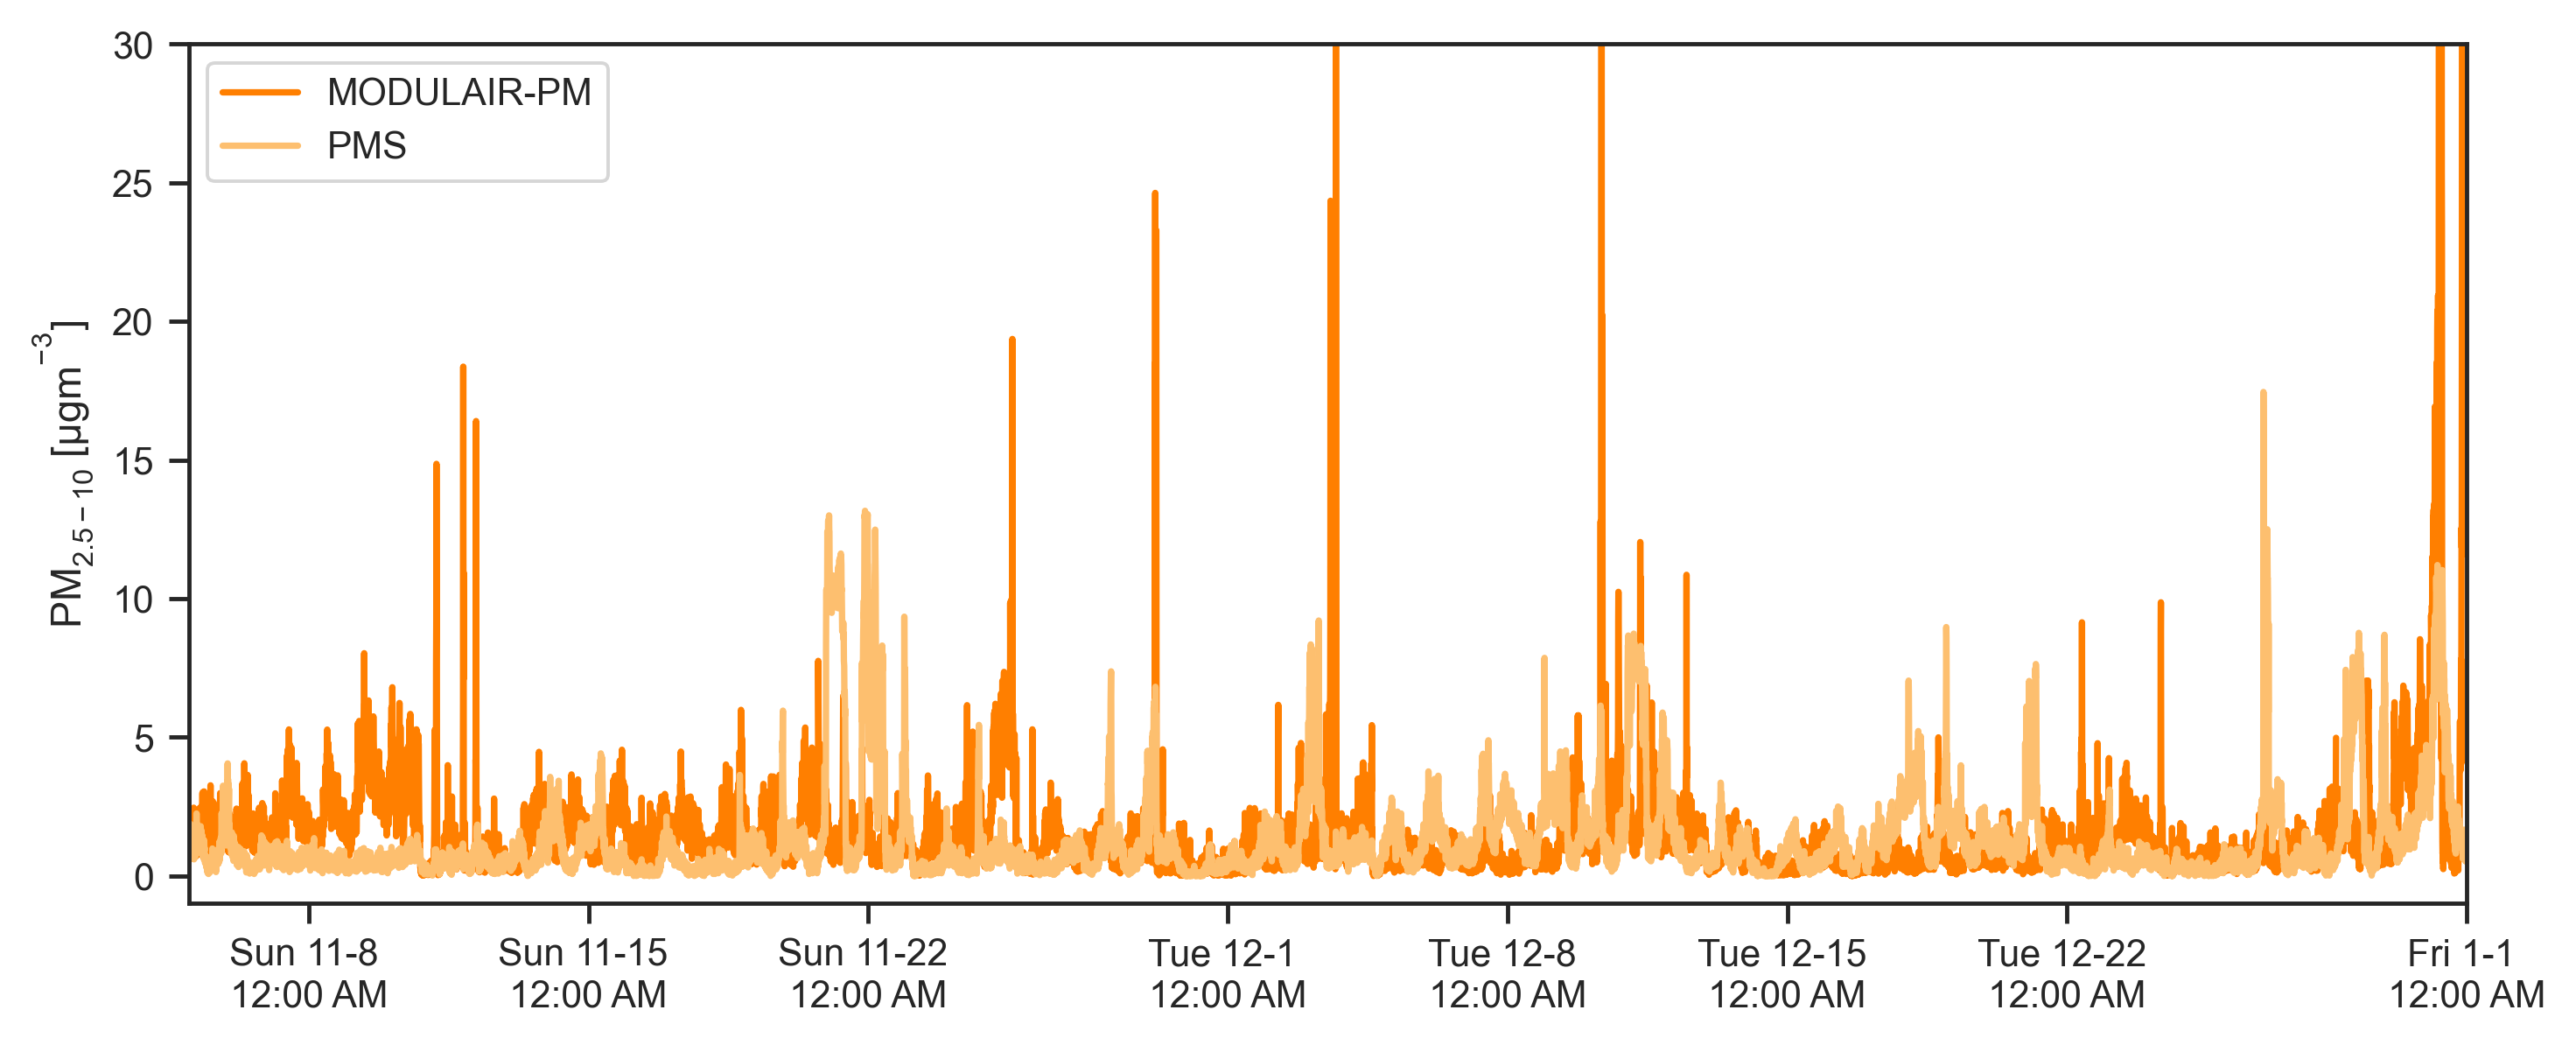

In [11]:
# force 'normal' text style for math text
mpl.rcParams['mathtext.default'] = 'regular'

def x_major_ticks(x, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    x = mdates.num2date(x)
    fmt = "%a %-m-%-d \n%I:%M %p"
    
    return x.strftime(fmt)

# set global seaborn params
sns.set("paper", "ticks", color_codes=True, palette='Paired')

# set up the matplotlib figure
fig, ax = plt.subplots(figsize = [8.5, 3.5], dpi = 350)

# grab the current color palette
cmap = sns.color_palette("Paired")

# plot the PM10 data
plt.plot(data['PM25-10_modpm'], lw=1.5, label="MODULAIR-PM", color=cmap[7])
plt.plot(data['PM25-10_neph'], lw=1.5, label='PMS', color=cmap[6])
plt.ylabel("$PM_{2.5-10} \; [\mu g m^{-3}]$")
plt.xlim('2020-11-05 00:00', '2021-01-01')
plt.legend(loc = 'upper left')
plt.ylim(-1, 30)

ax.xaxis.set_major_formatter(x_major_ticks)

# # remove the tiop and right spine
# sns.despine()

# force a tight layout
plt.tight_layout()

# save the figure
plt.savefig(
    folder + "Timeseries_PM25-10.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
# plt.close(fig)

In [120]:
import statsmodels.formula.api as smf

tmp = data.copy()[["PM25-10_neph" , "PM25-10_modpm"]]
tmp.rename(columns = {'PM25-10_neph':'PM25_10_neph', 'PM25-10_modpm':'PM25_10_modpm'}, inplace = True)

dat = tmp

results = smf.ols("PM25_10_neph ~ PM25_10_modpm",data=dat).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           PM25_10_neph   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     320.0
Date:                Tue, 01 Nov 2022   Prob (F-statistic):           8.77e-71
Time:                        09:13:22   Log-Likelihood:                -27297.
No. Observations:               13915   AIC:                         5.460e+04
Df Residuals:                   13913   BIC:                         5.461e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.1480      0.016     70.205

In [122]:
x_modpm_pm25_10 = [data['PM25-10_modpm'].min(), data['PM25-10_modpm'].max()]
y_neph_pm25_10 = [data['PM25-10_modpm'].min()*0.0850+1.1480, data['PM25-10_modpm'].max()*0.0850+1.1480]

In [135]:
folder = "/Users/zahrashivji/Dropbox/Shivji/Final Figures/Outdoor/"

fig, ax = plt.subplots(figsize = [4, 4], dpi = 350)

cmap = sns.color_palette("Paired")

# Add scatter points
plt.scatter(
    data["PM25-10_modpm"], 
    data["PM25-10_neph"], 
    marker = MarkerStyle('o'),
    alpha = 0.3,
    color = cmap[7])

# Add x=y line
plt.axline(
    [0, 0],
    [1, 1],
    c = 'black',
    dashes = (5, 5), lw= 1)

# Add ols trendline
plt.plot(
    x_modpm_pm25_10,
    y_neph_pm25_10,
    color = cmap[7])

plt.xlabel("MODULAIR-PM  " + "$PM_{2.5-10}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylabel("PMS  " + "$PM_{2.5-10}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylim(-0.4, 20)
plt.xlim(-2.5, 140)
plt.annotate('y = 0.09 x+1.15 \n $R^2$ = 0.02', (80,15), c = 'black')

ax.yaxis.set_major_formatter(y_major_ticks)

plt.tight_layout()

plt.savefig(
    folder + "Scatter_PM25-10.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
plt.close(fig)

## 2.4 Colored by ACSM

### 2.4.1 PM1

In [489]:
# # set the label fontsize
# xy_label_fontsize = 12

# force 'normal' text style for math text
mpl.rcParams['mathtext.default'] = 'regular'

def x_major_ticks(x, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    x = mdates.num2date(x)
    fmt = "%a %-m-%-d \n%I:%M %p"
    
    return x.strftime(fmt)

def y_major_ticks(y, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    y = int(y)
    
    return y

# set global seaborn params
sns.set("paper", "ticks", color_codes=True, palette='Paired')

# set up the matplotlib figure
fig, ax = plt.subplots(figsize = [8.5, 3.5], dpi = 350)

# grab the current color palette
cmap = sns.color_palette("flare", as_cmap=True)

# plot the PM1 data
plt.plot(data['PM1_modpm'], lw=1.5, label="MODULAIR-PM", color=cmap, norm = 'linear')
plt.plot(data['PM1_neph'], lw=1.5, label='PMS', color=cmap[0])
plt.plot(data['PM1_SMPS'], lw=1.5, label='SMPS', color='darkgray', linestyle='dashed')

plt.ylabel("$PM_{1} \; [\mu g m^{-3}]$")
plt.xlim('2020-11-05 00:00', '2021-01-01')
plt.legend(loc = 'upper left')

ax.xaxis.set_major_formatter(x_major_ticks)
ax.yaxis.set_major_formatter(y_major_ticks)

# # remove the tiop and right spine
# sns.despine()

# force a tight layout
plt.tight_layout()

# save the figure
plt.savefig(
    folder + "Timeseries_PM1_Class.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
# plt.close(fig)

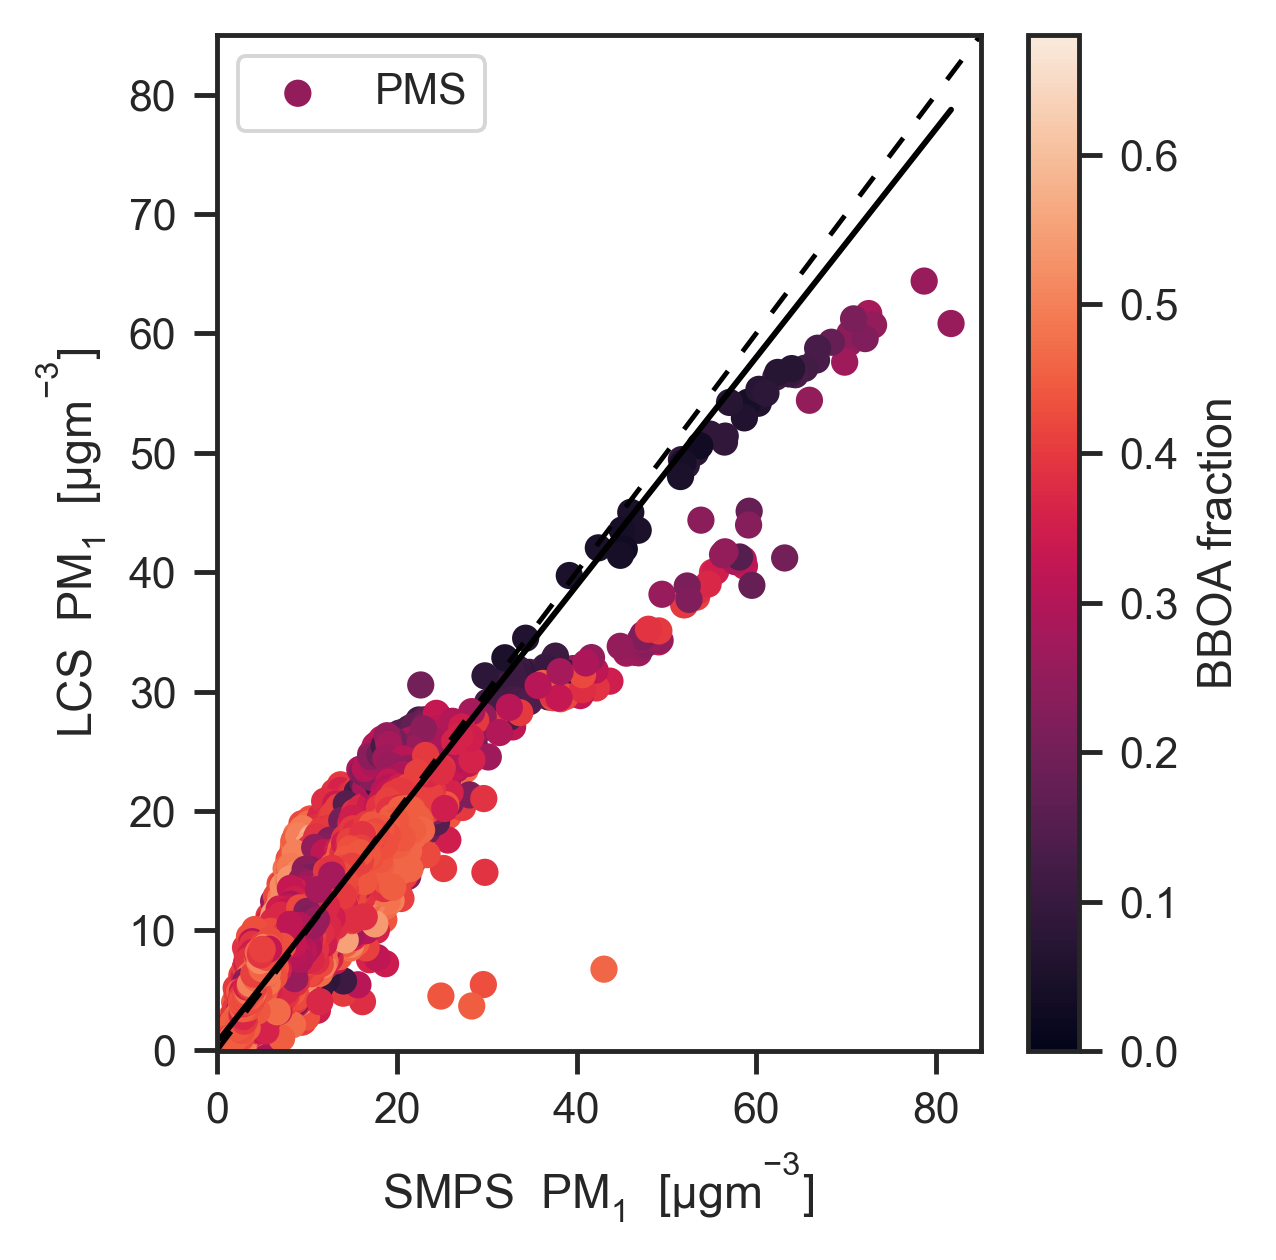

In [26]:
fig = plt.figure(figsize = [4, 4], dpi = 350)

# grab the current color palette
cmap = sns.color_palette("flare", as_cmap=True)


# Add scatter points
plt.scatter(
    data["PM1_SMPS"], 
    data["PM1_neph"], 
    marker = MarkerStyle('o'),
    c = data["MO-OOA_fraction"],
    label = 'PMS')

# plt.colorbar(label = 'RH %')

# plt.scatter(
#     data["PM1_SMPS"], 
#     data["PM1_modpm"], 
#     marker = MarkerStyle('o'),
#     c = data["BBOA_fraction"],
#     label = 'MODULAIR-PM')

plt.colorbar(label = 'BBOA fraction')

# grab the current color palette
cmap = sns.color_palette("Paired")

# Add x=y line
plt.axline(
    [0, 0],
    [1, 1],
    c = 'black',
    dashes = (5, 5), lw= 1)

# Add ols trendline
plt.plot(
    x_smps,
    y_neph,
    color = 'black')

# # Add ols trendline
# plt.plot(
#     x_smps,
#     y_modpm,
#     color = 'black')

plt.xlabel("SMPS  " + "$PM_{1}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylabel("LCS  " + "$PM_{1}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylim(-0.1, 85)
plt.xlim(-0.1, 85)
plt.legend(loc = 'upper left')
plt.rc('font', size=20)
# plt.annotate('y=0.36-0.43 \n $R^2$ = 0.76', (5.2,0.15), c = 'black')
# plt.annotate('y=0.74x-0.20 \n $R^2$ = 0.94', (2,4), c = 'black')

plt.tight_layout()

plt.savefig(
    folder + "Scatter_PM1_BBOA.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
# plt.close(fig)

### 2.4.2 PM2.5

In [496]:
# force 'normal' text style for math text
mpl.rcParams['mathtext.default'] = 'regular'

def x_major_ticks(x, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    x = mdates.num2date(x)
    fmt = "%a %-m-%-d \n%I:%M %p"
    
    return x.strftime(fmt)

def y_major_ticks(y, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    y = int(y)
    
    return y

# set global seaborn params
sns.set("paper", "ticks", color_codes=True, palette='Paired')

# set up the matplotlib figure
fig, ax = plt.subplots(figsize = [8.5, 3.5], dpi = 350)

# grab the current color palette
cmap = sns.color_palette("Paired")

# plot the PM1 data
plt.plot(data['PM25_modpm'], lw=1.5, label="MODULAIR-PM", color=cmap[3])
plt.plot(data['PM25_neph'], lw=1.5, label='PMS', color=cmap[2])

# overlay class time
plt.plot(data['PM25_modpm'].where(data['obseved_class']==1,  other =np.nan), lw=1.5, label = 'Data During Class', color=cmap[9])
plt.plot(data['PM25_neph'].where(data['obseved_class']==1,  other =np.nan), lw=1.5, label=None, color=cmap[9])

plt.ylabel("$PM_{2.5} \; [\mu g m^{-3}]$")
plt.xlim('2020-11-05 00:00', '2021-01-01')
plt.legend(loc = 'upper left')

ax.xaxis.set_major_formatter(x_major_ticks)
ax.yaxis.set_major_formatter(y_major_ticks)

# force a tight layout
plt.tight_layout()

# save the figure
plt.savefig(
    folder + "Timeseries_PM25_Class.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)

plt.close(fig)

In [514]:
fig = plt.figure(figsize = [4, 4], dpi = 350)

cmap = sns.color_palette("Paired")

# Add scatter points
plt.scatter(
    data["PM25_modpm"].where(data['obseved_class']==0), 
    data["PM25_neph"].where(data['obseved_class']==0), 
    marker = MarkerStyle('o'),
    alpha = 0.5,
    color = cmap[3],
    label = None)

# Add Class Coloring
plt.scatter(
    data["PM25_modpm"].where(data['obseved_class']==1,  other =np.nan), 
    data["PM25_neph"].where(data['obseved_class']==1,  other =np.nan), 
    marker = MarkerStyle('o'),
    alpha = 0.5,
    color = cmap[9],
    label = 'Data During Class')

# Add x=y line
plt.axline(
    [0, 0],
    [1, 1],
    c = 'black',
    dashes = (5, 5), lw= 1)

# Add ols trendline
plt.plot(
    x_modpm_pm25,
    y_neph_pm25,
    color = cmap[3])

plt.xlabel("MODULAIR-PM  " + "$PM_{2.5}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylabel("PMS  " + "$PM_{2.5}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylim(-0.1, 5.25)
plt.xlim(-0.1, 5.25)
plt.annotate('y=0.75x-0.56 \n $R^2$ = 0.90', (1.5,3), c = cmap[3])
plt.legend(loc = 'upper left')

plt.tight_layout()


plt.savefig(
    folder + "Scatter_PM25_Class.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
plt.close(fig)

### 2.4.3 PM10

In [499]:
# force 'normal' text style for math text
mpl.rcParams['mathtext.default'] = 'regular'

def x_major_ticks(x, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    x = mdates.num2date(x)
    fmt = "%a %-m-%-d \n%I:%M %p"
    
    return x.strftime(fmt)

def y_major_ticks(y, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    y = int(y)
    
    return y

# set global seaborn params
sns.set("paper", "ticks", color_codes=True, palette='Paired')

# set up the matplotlib figure
fig, ax = plt.subplots(figsize = [8.5, 3.5], dpi = 350)

# grab the current color palette
cmap = sns.color_palette("Paired")

# plot the PM1 data
plt.plot(data['PM10_modpm'], lw=1.5, label="MODULAIR-PM", color=cmap[7])
plt.plot(data['PM10_neph'], lw=1.5, label='PMS', color=cmap[6])

# overlay class time
plt.plot(data['PM10_modpm'].where(data['obseved_class']==1,  other =np.nan), lw=1.5, label = 'Data During Class', color=cmap[9])
plt.plot(data['PM10_neph'].where(data['obseved_class']==1,  other =np.nan), lw=1.5, label=None, color=cmap[9])

plt.ylabel("$PM_{10} \; [\mu g m^{-3}]$")
plt.xlim('2020-11-05 00:00', '2021-01-01')
plt.legend(loc = 'upper left')

ax.xaxis.set_major_formatter(x_major_ticks)
ax.yaxis.set_major_formatter(y_major_ticks)

# force a tight layout
plt.tight_layout()

# save the figure
plt.savefig(
    folder + "Timeseries_PM10_Class.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)

plt.close(fig)

In [512]:
fig, ax = plt.subplots(figsize = [4, 4], dpi = 350)

cmap = sns.color_palette("Paired")

# Add scatter points
plt.scatter(
    data["PM10_modpm"].where(data['obseved_class']==0), 
    data["PM10_neph"].where(data['obseved_class']==0), 
    marker = MarkerStyle('o'),
    alpha = 0.5,
    color = cmap[7],
    label = None)

# Add Class Coloring
plt.scatter(
    data["PM10_modpm"].where(data['obseved_class']==1,  other =np.nan), 
    data["PM10_neph"].where(data['obseved_class']==1,  other =np.nan), 
    marker = MarkerStyle('o'),
    alpha = 0.5,
    color = cmap[9],
    label = 'Data During Class')

# Add x=y line
plt.axline(
    [0, 0],
    [1, 1],
    c = 'black',
    dashes = (5, 5), lw= 1)

# Add ols trendline
plt.plot(
    x_modpm_pm10,
    y_neph_pm10,
    color = cmap[7])

plt.xlabel("MODULAIR-PM  " + "$PM_{10}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylabel("PMS  " + "$PM_{10}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylim(-0.5, 20)
plt.xlim(-0.5, 20)
plt.annotate('y=0.06x+0.31 \n $R^2$ = 0.03', (10,5), c = cmap[7])
plt.legend(loc = 'upper left')

ax.yaxis.set_major_formatter(y_major_ticks)

plt.tight_layout()


plt.savefig(
    folder + "Scatter_PM10_Class.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
plt.close(fig)

## 2.5 Bias Plots 

### 2.5.1 Geo. Mean Diameter (GM)

In [136]:
from matplotlib.markers import MarkerStyle

# Create temporary df to combine timeseries data and bias plot data
    # Columns need to have sampe dimensions to plot on same graph
tmp = data.copy()[["Geo. Mean (nm)", "PMS PM1 bias", "modpm PM1 bias", 'rh', 'PM1_SMPS']]

# Add gm data: first create empty column in tmp, then fill empty column w gm values
tmp['gm_group'] = pd.Series([np.nan]*tmp.shape[0])
tmp['gm_group'].iloc[0:gm.shape[0]] = gm["Geo. Mean (nm)"]
tmp['PMS_bias_gm'] = pd.Series([np.nan]*tmp.shape[0])
tmp['PMS_bias_gm'].iloc[0:gm.shape[0]] = gm["PMS PM1 bias"]
tmp['modpm_bias_gm'] = pd.Series([np.nan]*tmp.shape[0])
tmp['modpm_bias_gm'].iloc[0:gm.shape[0]] = gm["modpm PM1 bias"]

# Add rh data
tmp['rh_group'] = pd.Series([np.nan]*tmp.shape[0])
tmp['rh_group'].iloc[0:rh.shape[0]] = rh["rh"]
tmp['PMS_bias_rh'] = pd.Series([np.nan]*tmp.shape[0])
tmp['PMS_bias_rh'].iloc[0:rh.shape[0]] = rh["PMS PM1 bias"]
tmp['modpm_bias_rh'] = pd.Series([np.nan]*tmp.shape[0])
tmp['modpm_bias_rh'].iloc[0:rh.shape[0]] = rh["modpm PM1 bias"]

# Add ml data
tmp['ml_group'] = pd.Series([np.nan]*tmp.shape[0])
tmp['ml_group'].iloc[0:ml.shape[0]] = ml["PM1_SMPS"]
tmp['PMS_bias_ml'] = pd.Series([np.nan]*tmp.shape[0])
tmp['PMS_bias_ml'].iloc[0:ml.shape[0]] = ml["PMS PM1 bias"]
tmp['modpm_bias_ml'] = pd.Series([np.nan]*tmp.shape[0])
tmp['modpm_bias_ml'].iloc[0:ml.shape[0]] = ml["modpm PM1 bias"]

# set global seaborn params
sns.set("paper", "ticks", color_codes=True, palette='Paired')

# set up the matplotlib figure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), dpi = 350, edgecolor  = 'black', sharex=False, sharey=True)

# grab the current color palette
cmap = sns.color_palette("Paired")

# plot the gm data
ax[0].axhline(lw = 1, color='black')
ax[0].scatter(tmp["Geo. Mean (nm)"], tmp['PMS PM1 bias'], s = 30, marker = MarkerStyle('o'), alpha = 0.5, label="PMS", color=cmap[0])
ax[0].scatter(tmp["Geo. Mean (nm)"], tmp['modpm PM1 bias'], s=30, marker = MarkerStyle('o'), alpha = 0.5, label="MODULAIR-PM", color=cmap[1])
ax[0].scatter(tmp["gm_group"], tmp['PMS_bias_gm'], s = 70, marker = 'd', label=None, edgecolors='black', lw = 1.5, color=cmap[0])
ax[0].scatter(tmp["gm_group"], tmp['modpm_bias_gm'], s = 70, marker = 'd', edgecolors='black', label=None, lw = 1.5, color=cmap[1])
ax[0].axhline(lw = 1, color='black')
ax[0].set_ylabel("Bias  " + r'$[\frac{LCS-Reference}{Reference}]$')
ax[0].set_xlabel("Geo. Mean Diameter " + "$[nm]$")
ax[0].set_ylim(-1.1, 2)
ax[0].set_xlim(20, 140)

# plot the rh data
ax[1].scatter(tmp["rh"], tmp['PMS PM1 bias'], s = 30, marker = MarkerStyle('o'), alpha = 0.5, label="PMS", color=cmap[0])
ax[1].scatter(tmp["rh"], tmp['modpm PM1 bias'], s=30, marker = MarkerStyle('o'), alpha = 0.5, label="MODULAIR-PM", color=cmap[1])
ax[1].scatter(tmp["rh_group"], tmp['PMS_bias_rh'], s = 70, marker = 'd', label="PMS", edgecolors='black', lw = 1.5, color=cmap[0])
ax[1].scatter(tmp["rh_group"], tmp['modpm_bias_rh'], s = 70, marker = 'd', edgecolors='black', label="PMS", lw = 1.5, color=cmap[1])
ax[1].axhline(lw = 1, color='black')
ax[1].set_xlabel("Relative " + "Humidity " + "$[\%]$")
ax[1].set_ylim(-1.1, 1.1)
ax[1].set_xlim(16, 100)

# plot the ml data
ax[2].scatter(tmp["PM1_SMPS"], tmp['PMS PM1 bias'], s = 30,marker = MarkerStyle('o'), alpha = 0.5, label="PMS", color=cmap[0])
ax[2].scatter(tmp["PM1_SMPS"], tmp['modpm PM1 bias'], s=30, marker = MarkerStyle('o'), alpha = 0.5, label="MODULAIR-PM", color=cmap[1])
ax[2].scatter(tmp["ml_group"], tmp['PMS_bias_ml'], s = 70, marker = 'd', label="PMS", edgecolors='black', lw = 1.5, color=cmap[0])
ax[2].scatter(tmp["ml_group"], tmp['modpm_bias_ml'], s = 70, marker = 'd', edgecolors='black', label="PMS", lw = 1.5, color=cmap[1])
ax[2].axhline(lw = 1, color='black')
ax[2].set_xlabel("SMPS " +  "$PM_1$" + " Mass Loading " +  "$[\mu g m^{-3}]$")
ax[2].set_ylim(-1.1, 2)
ax[2].set_xlim(-1, 85)

plt.tight_layout()

ax[0].legend(loc = 'upper left')

plt.savefig(
    folder + "Bias.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)

plt.close(fig)

## 2.6 SMPS PM1 dNdlogDp

### 2.6.1. Whole time period

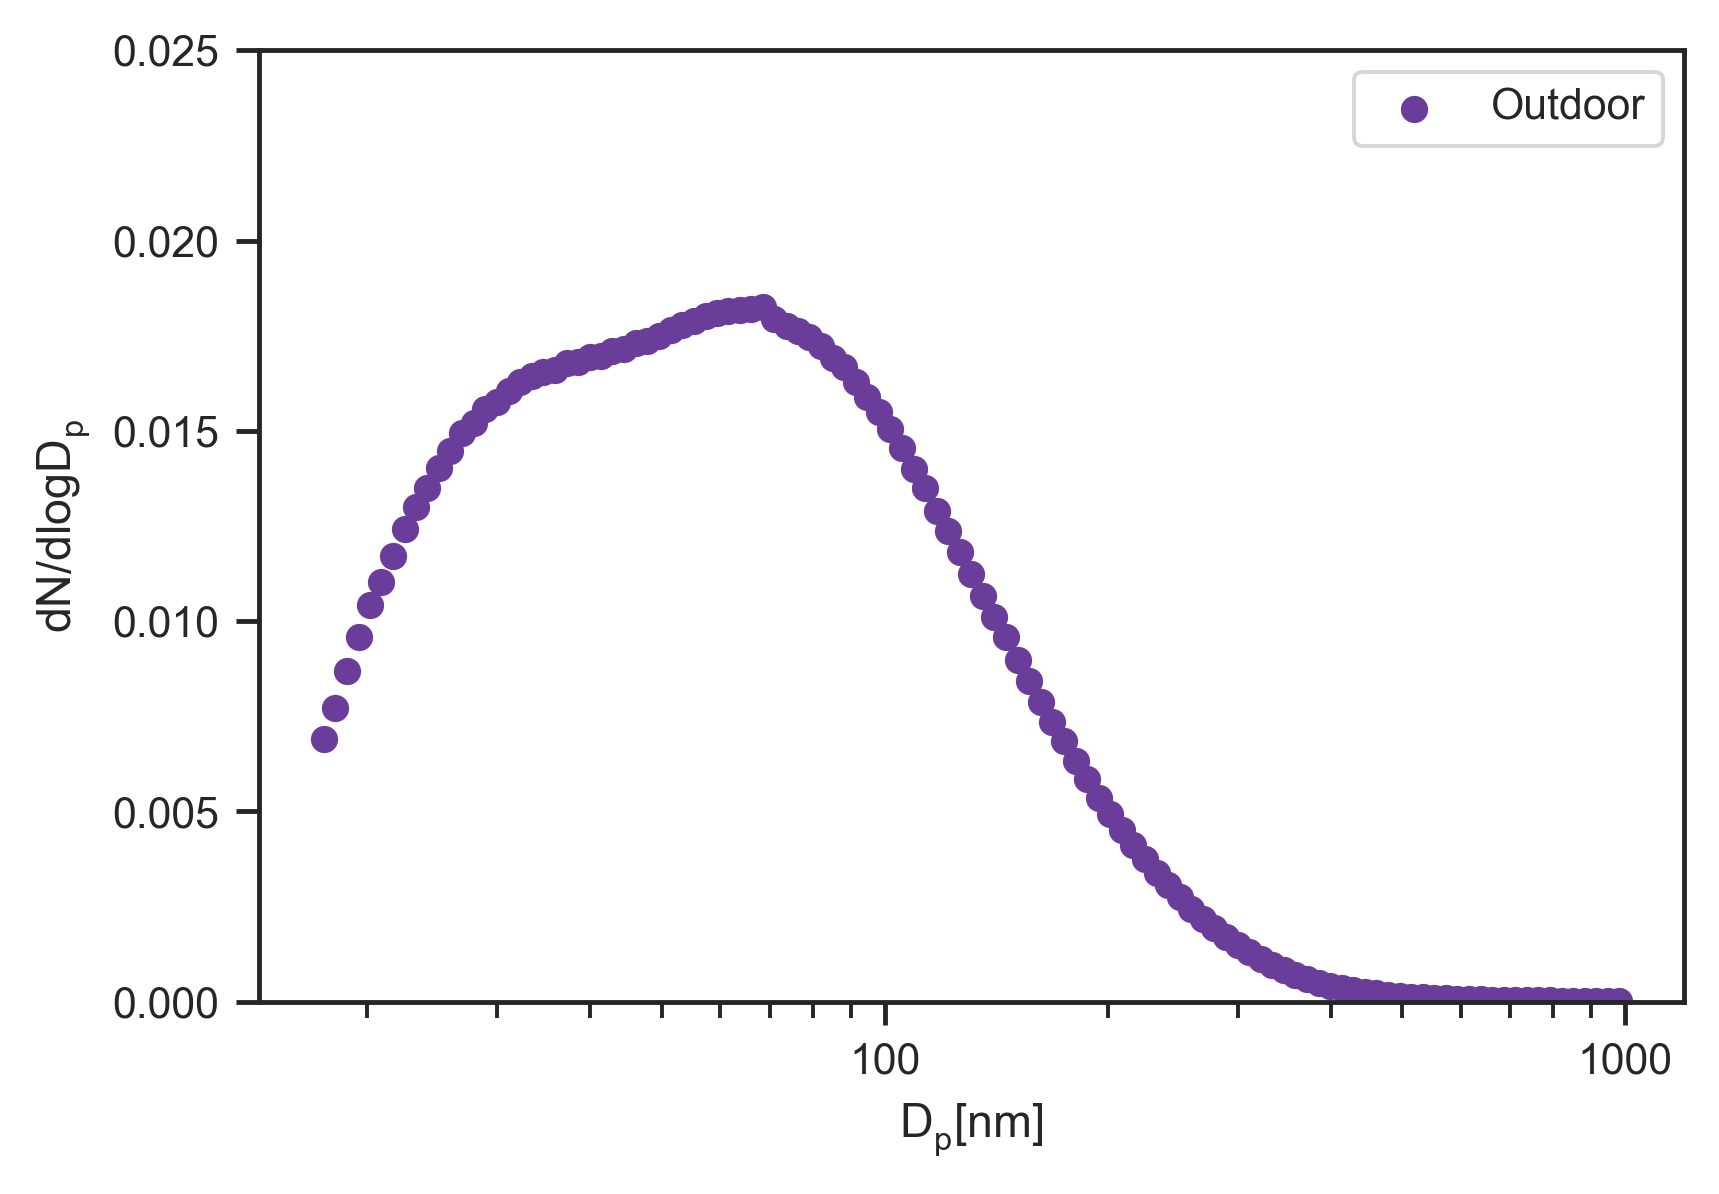

In [149]:
fig, ax = plt.subplots(figsize = [5, 3.5], dpi = 350)

def y_major_ticks(y, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    y = int(float(y)*1000)
    
    return y

numerator1 = obj.dndlogdp.mean()
denominator1 = obj.dndlogdp.mean().sum()

plt.scatter(
    x=obj.midpoints,
    y= numerator1/denominator1,
    color=cmap[9],
    label = 'Outdoor')

plt.xscale('log')
plt.ylim(0, 0.025)
plt.xlabel("${D}_p  [nm]$")
plt.ylabel("${dN/dlogD}_p$")

ax.xaxis.set_major_formatter(y_major_ticks)

plt.tight_layout()

plt.legend(loc = 'upper right')

plt.savefig(
    folder + "SMPS dNdlogDp_overlay.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)

plt.close(fig)

### 2.6.2 Identifying PMS PM1 arms

In [251]:
data['Slope_PMS'] = data['PM1_neph'] / data['PM1_SMPS']
data['Slope_modpm'] = data['PM1_modpm'] / data['PM1_SMPS']

group1_PMS = data.where(data['Slope_PMS'] > 1., other = np.nan).dropna()
group1_modpm = data.where(data['Slope_modpm'] > 1., other = np.nan).dropna()

#B uild a generic Particle Sizer Object 
obj1 = smps.GenericParticleSizer(
    data=df2.loc[group1_PMS.index].copy(),
    bins=bins,
    fmt='dn',
    dp_units='nm',
    bin_labels=binlabels
)

group2_PMS = data.where(((data['Slope_PMS'] < 1.) & (data['Slope_PMS'] > 0.8)), other = np.nan).dropna()
group2_modpm = data.where(((data['Slope_modpm'] < 1.) & (data['Slope_modpm'] > 0.8)), other = np.nan).dropna()

#B uild a generic Particle Sizer Object 
obj2 = smps.GenericParticleSizer(
    data=df2.loc[group2_PMS.index].copy(),
    bins=bins,
    fmt='dn',
    dp_units='nm',
    bin_labels=binlabels
)

group3_PMS = data.where(((data['Slope_PMS'] < 0.8) & (data['Slope_PMS'] > 0.)), other = np.nan).dropna()
group3_modpm = data.where(((data['Slope_modpm'] < 0.8) & (data['Slope_modpm'] > 0.5)), other = np.nan).dropna()

#B uild a generic Particle Sizer Object 
obj3 = smps.GenericParticleSizer(
    data=df2.loc[group3_PMS.index].copy(),
    bins=bins,
    fmt='dn',
    dp_units='nm',
    bin_labels=binlabels
)

group4_PMS = data.where((data['Slope_PMS'] < 0.5), other = np.nan).dropna()
group4_modpm = data.where((data['Slope_modpm'] < 0.5), other = np.nan).dropna()

#B uild a generic Particle Sizer Object 
obj4 = smps.GenericParticleSizer(
    data=df2.loc[group4_PMS.index].copy(),
    bins=bins,
    fmt='dn',
    dp_units='nm',
    bin_labels=binlabels
)

# plot on graph
folder = "/Users/zahrashivji/Dropbox/Shivji/Final Figures/Outdoor/"

fig = plt.figure(figsize = [4, 4], dpi = 350)

cmap = sns.color_palette("Paired")

# Add scatter points
plt.scatter(
    group1_PMS["PM1_SMPS"], 
    group1_PMS["PM1_neph"], 
    marker = MarkerStyle('o'),
    alpha = 0.7,
    color = cmap[0],
    label = 'Slope >1')

# Add scatter points
plt.scatter(
    group2_PMS["PM1_SMPS"], 
    group2_PMS["PM1_neph"], 
    marker = MarkerStyle('o'),
    alpha = 0.7,
    color = cmap[1],
    label = '1 > Slope >0.8')

# Add scatter points
plt.scatter(
    group3_PMS["PM1_SMPS"], 
    group3_PMS["PM1_neph"], 
    marker = MarkerStyle('o'),
    alpha = 0.7,
    color = cmap[3],
    label = '0.8 > Slope > 0.5')

# Add scatter points
plt.scatter(
    group4_PMS["PM1_SMPS"], 
    group4_PMS["PM1_neph"], 
    marker = MarkerStyle('o'),
    alpha = 0.7,
    color = cmap[4],
    label = 'Slope < 0.5')

# # Add scatter points
# plt.scatter(
#     data["PM1_SMPS"], 
#     data["PM1_modpm"], 
#     marker = MarkerStyle('o'),
#     alpha = 0.5,
#     color = cmap[1],
#     label = 'MODULAIR-PM',
#     zorder = 0)

# Add x=y line
plt.axline(
    [0, 0],
    [1, 1],
    c = 'black',
    dashes = (5, 5), lw= 1)

# # Add ols trendline
# plt.plot(
#     x_smps,
#     y_neph,
#     color = cmap[0])

# # Add ols trendline
# plt.plot(
#     x_smps,
#     y_modpm,
#     color = cmap[1])

# Add slope grouping line
plt.axline(
    [0, 0],
    [1, 0.8],
    c = 'gray',
    dashes = (5, 5), lw= 1)

# Add slope grouping line
plt.axline(
    [0, 0],
    [2, 1],
    c = 'gray',
    dashes = (5, 5), lw= 1)

plt.xlabel("SMPS  " + "$PM_{1}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylabel("LCS  " + "$PM_{1}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylim(-0.5, 85)
plt.xlim(-0.5, 85)
plt.legend(loc = 'upper left')
plt.annotate('y = 0.5x', (60, 25))
plt.annotate('y = x', (30, 45))
plt.annotate('y = 0.8x', (65, 45))
# plt.annotate('y=0.96+0.64 \n $R^2$ = 0.85', (35, 60), c = cmap[0])
# plt.annotate('y=0.90+1.20 \n $R^2$ = 0.81', (60,20), c = cmap[1])

plt.tight_layout()

plt.savefig(
    folder + "Scatter_PM1_PMS_Arms.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
plt.close(fig)

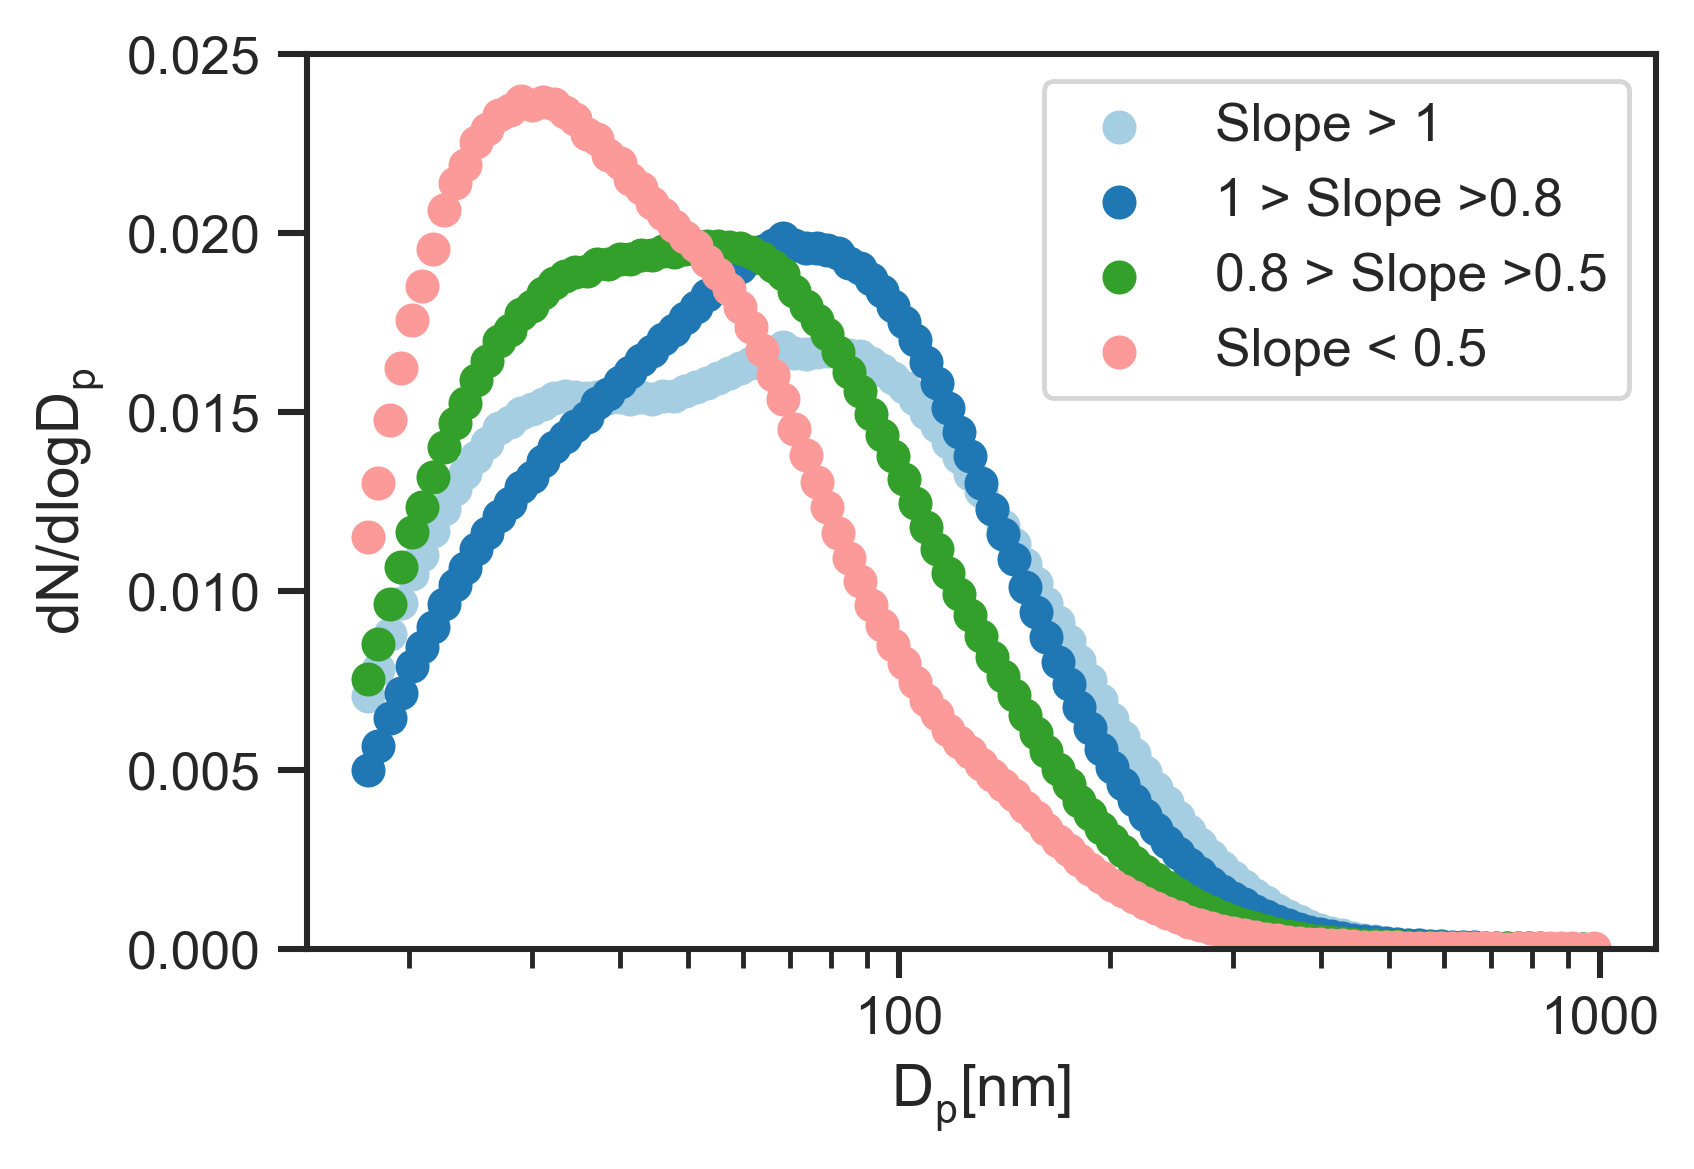

In [250]:
fig, ax = plt.subplots(figsize = [5, 3.5], dpi = 350)

def y_major_ticks(y, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    y = int(float(y)*1000)
    
    return y

numerator1 = obj1.dndlogdp.mean()
denominator1 = obj1.dndlogdp.mean().sum()

plt.scatter(
    x=obj.midpoints,
    y= numerator1/denominator1,
    color=cmap[0],
    label = 'Slope > 1')

numerator2 = obj2.dndlogdp.mean()
denominator2 = obj2.dndlogdp.mean().sum()

plt.scatter(
    x=obj.midpoints,
    y= numerator2/denominator2,
    color=cmap[1],
    label = '1 > Slope >0.8')

numerator3 = obj3.dndlogdp.mean()
denominator3 = obj3.dndlogdp.mean().sum()

plt.scatter(
    x=obj.midpoints,
    y= numerator3/denominator3,
    color=cmap[3],
    label = '0.8 > Slope >0.5')

numerator4 = obj4.dndlogdp.mean()
denominator4 = obj4.dndlogdp.mean().sum()

plt.scatter(
    x=obj.midpoints,
    y= numerator4/denominator4,
    color=cmap[4],
    label = 'Slope < 0.5')

plt.xscale('log')
plt.ylim(0, 0.025)
plt.xlabel("${D}_p  [nm]$")
plt.ylabel("${dN/dlogD}_p$")

ax.xaxis.set_major_formatter(y_major_ticks)

plt.tight_layout()

plt.legend(loc = 'upper right')

plt.savefig(
    folder + "SMPS dNdlogDp_PMS_PM1_Arms.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)

# plt.close(fig)

### 2.6.3 Identifying MODULAIR-PM PM1 arms

In [ ]:
data['Slope_modpm'] = data['PM1_modpm'] / data['PM1_SMPS']

group1_modpm = data.where(data['Slope_modpm'] > 1., other = np.nan).dropna()

# Build a generic Particle Sizer Object 
obj1 = smps.GenericParticleSizer(
    data=df2.loc[group1_PMS.index].copy(),
    bins=bins,
    fmt='dn',
    dp_units='nm',
    bin_labels=binlabels
)

group2_modpm = data.where(((data['Slope_modpm'] < 1.) & (data['Slope_modpm'] > 0.8)), other = np.nan).dropna()

# Build a generic Particle Sizer Object 
obj2 = smps.GenericParticleSizer(
    data=df2.loc[group2_PMS.index].copy(),
    bins=bins,
    fmt='dn',
    dp_units='nm',
    bin_labels=binlabels
)

group3_modpm = data.where(((data['Slope_modpm'] < 0.8) & (data['Slope_modpm'] > 0.5)), other = np.nan).dropna()

# Build a generic Particle Sizer Object 
obj3 = smps.GenericParticleSizer(
    data=df2.loc[group3_PMS.index].copy(),
    bins=bins,
    fmt='dn',
    dp_units='nm',
    bin_labels=binlabels
)

group4_PMS = data.where((data['Slope_PMS'] < 0.5), other = np.nan).dropna()
group4_modpm = data.where((data['Slope_modpm'] < 0.5), other = np.nan).dropna()

#B uild a generic Particle Sizer Object 
obj4 = smps.GenericParticleSizer(
    data=df2.loc[group4_PMS.index].copy(),
    bins=bins,
    fmt='dn',
    dp_units='nm',
    bin_labels=binlabels
)

# plot on graph
folder = "/Users/zahrashivji/Dropbox/Shivji/Final Figures/Outdoor/"

fig = plt.figure(figsize = [4, 4], dpi = 350)

cmap = sns.color_palette("Paired")

# Add scatter points
plt.scatter(
    group1_PMS["PM1_SMPS"], 
    group1_PMS["PM1_neph"], 
    marker = MarkerStyle('o'),
    alpha = 0.7,
    color = cmap[0],
    label = 'Slope >1')

# Add scatter points
plt.scatter(
    group2_PMS["PM1_SMPS"], 
    group2_PMS["PM1_neph"], 
    marker = MarkerStyle('o'),
    alpha = 0.7,
    color = cmap[1],
    label = '1 > Slope >0.8')

# Add scatter points
plt.scatter(
    group3_PMS["PM1_SMPS"], 
    group3_PMS["PM1_neph"], 
    marker = MarkerStyle('o'),
    alpha = 0.7,
    color = cmap[3],
    label = '0.8 > Slope > 0.5')

# Add scatter points
plt.scatter(
    group4_PMS["PM1_SMPS"], 
    group4_PMS["PM1_neph"], 
    marker = MarkerStyle('o'),
    alpha = 0.7,
    color = cmap[4],
    label = 'Slope < 0.5')

# # Add scatter points
# plt.scatter(
#     data["PM1_SMPS"], 
#     data["PM1_modpm"], 
#     marker = MarkerStyle('o'),
#     alpha = 0.5,
#     color = cmap[1],
#     label = 'MODULAIR-PM',
#     zorder = 0)

# Add x=y line
plt.axline(
    [0, 0],
    [1, 1],
    c = 'black',
    dashes = (5, 5), lw= 1)

# # Add ols trendline
# plt.plot(
#     x_smps,
#     y_neph,
#     color = cmap[0])

# # Add ols trendline
# plt.plot(
#     x_smps,
#     y_modpm,
#     color = cmap[1])

# Add slope grouping line
plt.axline(
    [0, 0],
    [1, 0.8],
    c = 'gray',
    dashes = (5, 5), lw= 1)

# Add slope grouping line
plt.axline(
    [0, 0],
    [2, 1],
    c = 'gray',
    dashes = (5, 5), lw= 1)

plt.xlabel("SMPS  " + "$PM_{1}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylabel("LCS  " + "$PM_{1}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylim(-0.5, 85)
plt.xlim(-0.5, 85)
plt.legend(loc = 'upper left')
plt.annotate('y = 0.5x', (60, 25))
plt.annotate('y = x', (30, 45))
plt.annotate('y = 0.8x', (65, 45))
# plt.annotate('y=0.96+0.64 \n $R^2$ = 0.85', (35, 60), c = cmap[0])
# plt.annotate('y=0.90+1.20 \n $R^2$ = 0.81', (60,20), c = cmap[1])

plt.tight_layout()

plt.savefig(
    folder + "Scatter_PM1_PMS_Arms.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
plt.close(fig)

## 2.7 Size Bins Fractions

[81.69962786238278, 4.755381928097826, 13.544990209519392]

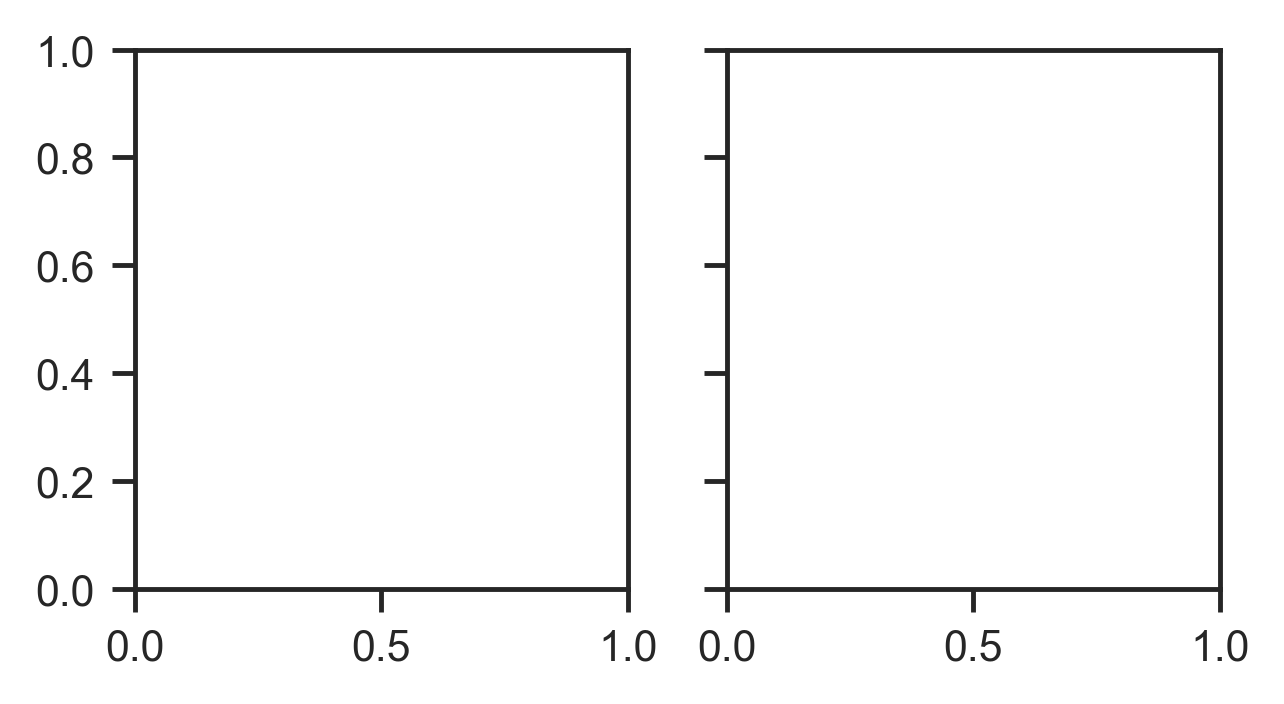

In [20]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, dpi = 350, figsize = [4, 2], sharey = True)

# x values
x = ['$PM_{1}$', '$PM_{2.5}$', '$PM_{10}$']

# Calculate modpm fracs
pm1_modpm = data['PM1_modpm'].mean()
pm25_modpm =  (data['PM25_modpm']-data['PM1_modpm']).mean()
pm10_modpm = (data['PM10_modpm']-data['PM25_modpm']).mean()

total_modpm = pm1_modpm + pm25_modpm + pm10_modpm

pm1_modpm = pm1_modpm/total_modpm*100
pm25_modpm = pm25_modpm/total_modpm*100
pm10_modpm = pm10_modpm/total_modpm*100

height_modpm = [pm1_modpm, pm25_modpm, pm10_modpm]

# Calculate neph fracs
pm1_neph = data['PM1_neph'].mean()
pm25_neph =  (data['PM25_neph']-data['PM1_neph']).mean()
pm10_neph = (data['PM10_neph']-data['PM25_neph']).mean()

total_neph = pm1_neph + pm25_neph + pm10_neph

pm1_neph = pm1_neph/total_neph*100
pm25_neph = pm25_neph/total_neph*100
pm10_neph = pm10_neph/total_neph*100

height_neph = [pm1_neph, pm25_neph, pm10_neph]

# ax[0].bar(x, height_modpm, width=0.7, color = [cmap[1], cmap[3], cmap[7]])
# ax[1].bar(x, height_neph, width=0.7, color = [cmap[0], cmap[2], cmap[6]])

# ax[0].set_title('MODULAIR-PM')
# ax[1].set_title('PMS')
# ax[0].set_ylabel('Percent [%]')
# ax[0].set_ylim(0,100)

# plt.tight_layout()

# plt.savefig(
#     folder + "PM_fractions.png",
#     format = 'png',
#     dpi='figure',
#     edgecolor='black',
#     transparent = True)

# plt.close(fig)

height_modpm

## 2.8 Linear Regression Result Map

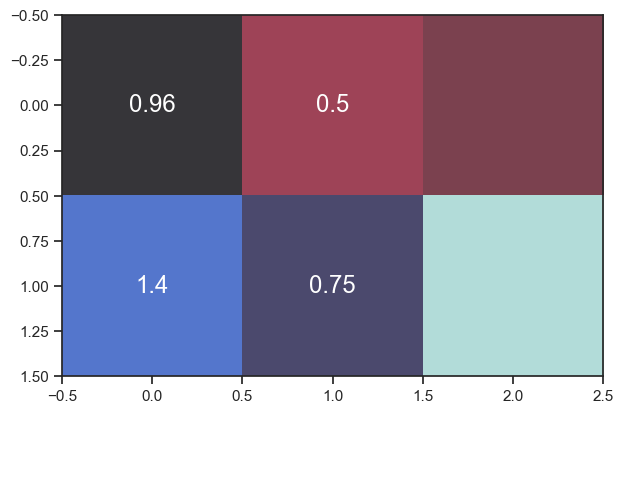

In [302]:
### HARRD CODED

x = ["Indoor", "Outdoor"]
y = ["$PM_1$", "$PM_{2.5}$", "$PM_{10}$"]

harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])

out_r2 = [0.84, 0.79, 0.66]
out_s = [0.96, 1.40, 1.30]

in_r2 = [0.85, 0.90, 0.03]
in_s = [0.50, 0.75, 0.06]

r2 = np.array([out_s, in_s])
s = np.array([out_s, in_s])

cmap = sns.color_palette("icefire", as_cmap=True)

fig, ax = plt.subplots()
im = ax.imshow(r2, cmap = cmap, alpha = 0.9, vmin = 0, vmax = 2)

# # Show all ticks and label them with the respective list entries
# ax.set_xticks(np.arange(len(x)), labels=x)
# ax.set_yticks(np.arange(len(y)), labels=y)

# # Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(x)):
    for j in range(len(y)):
        text = ax.text(i, j, r2[i,j],
                       ha="center", va="center", color="w", size = 'x-large')

fig.tight_layout()
plt.show()

In [21]:
data['PM1_SMPS'].mean()

9.065090420503726